In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, log_loss
from sklearn.utils import resample

import random
import pandas as pd
import numpy as np
import os
import time

from tqdm import tqdm
import matplotlib.pyplot as plt

In [39]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## visualization

<BarContainer object of 15 artists>

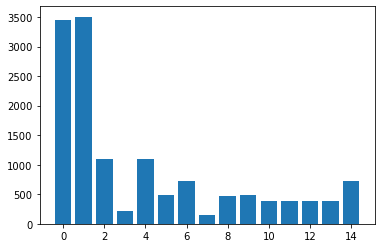

In [95]:
size0 = []
for i in range(16):
    if i == 10: 
        continue
    size0.append(len(os.listdir(f'dataset0/train/class{i}'))) 
    
plt.bar(np.arange(15), size0)

<BarContainer object of 11 artists>

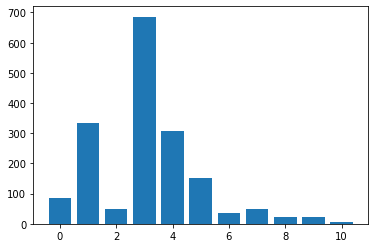

In [84]:
size1 = []
for i in range(11):
    size1.append(len(os.listdir(f'dataset1/train/class{i}'))) 
    
plt.bar(np.arange(11), size1)

# set data
- dataset1 의 전이 학습을 위해 train/validation split

In [85]:
dataset0_classes = os.listdir('dataset0/train/')
dataset0_label_encoder = LabelEncoder()

dataset0_label_encoder.fit(dataset0_classes)
print(dataset0_label_encoder.classes_)

dataset1_classes = os.listdir('dataset1/train/')
dataset1_label_encoder = LabelEncoder()

dataset1_label_encoder.fit(dataset1_classes)
print(dataset1_label_encoder.classes_)

['class0' 'class1' 'class11' 'class12' 'class13' 'class14' 'class15'
 'class2' 'class3' 'class4' 'class5' 'class6' 'class7' 'class8' 'class9']
['class0' 'class1' 'class10' 'class2' 'class3' 'class4' 'class5' 'class6'
 'class7' 'class8' 'class9']


In [86]:
dataset0_dir = 'dataset0/'
dataset1_dir = 'dataset1/'

dataset0_train_dir = dataset0_dir + 'train/'
dataset0_test_dir = dataset0_dir + 'test/'

dataset1_train_dir = dataset1_dir + 'train/'
dataset1_val_dir = dataset1_dir + 'val/'
dataset1_test_dir = dataset1_dir + 'test/'

In [87]:
# split train/val for dataset1

os.mkdir(dataset1_val_dir)
for cls in dataset1_classes:
    os.mkdir(os.path.join(dataset1_val_dir, cls))
    
for i in range(11):
    num_ratio = int(0.2 * len(os.listdir(f'dataset1/train/class{i}')))
    mv_files = random.sample(os.listdir(f'dataset1/train/class{i}'), num_ratio)
    for mf in mv_files:
        os.rename(f'dataset1/train/class{i}/{mf}', f'dataset1/val/class{i}/{mf}')

directory structure

```
main/
|-- programmers_dev-matching_yunsoo-woo_final.ipynb
|-- dataset0/
|   |-- train/
|   |   |-- class0/
|   |   |   |-- 0.csv
|   |   |   |-- 1.csv
|   |   |   |-- ...
|   |   |-- class1/
|   |   |-- ...
|   |   |-- class15/
|   |-- test/
|   |   |-- class0/
|   |   |-- class1/
|   |   |-- ...
|   |   |-- class15/
|-- dataset1/
|   |-- train/
|   |   |-- class0/
|   |   |   |-- 0.csv
|   |   |   |-- 1.csv
|   |   |   |-- ...
|   |   |-- class1/
|   |   |-- ...
|   |   |-- class15/
|   |-- val/
|   |   |-- class0/
|   |   |-- class1/
|   |   |-- ...
|   |   |-- class15/
|   |-- test/
|   |   |-- 103.csv
|   |   |-- ...
|   |   |-- 869.csv
```

# DataLoader

In [262]:
# 가장 개수가 많은 label 데이터에 대해 over-sampling
# augmentation은 training 데이터에만 적용

def create_dataset_resampled(dataset_dir):
    X, y = [], []
    labels = os.listdir(dataset_dir)
    labels = sorted(labels)
    for label in labels:
        file_list = os.listdir(dataset_dir + label + '/')
        for f in file_list:
            temp = pd.read_csv(dataset_dir + label + '/' + f)
            X.append(torch.from_numpy(temp.values))
            
    new_X = []
    length = [len(os.listdir(dataset_dir + label + '/')) for label in labels]
    n_samples = max(length)
    max_idex = length.index(n_samples)
    length.insert(0, 0)
    for r in range(len(labels)):
        start = length[r]
        end = start + length[r+1]
        if r == max_idex:
            new_X += X[start:end]
        else:
            new_X += resample(X[start:end], n_samples=n_samples)
    X = pad_sequence(new_X, batch_first=True) # B x T x *
    
    y = []
    for label in labels:
        for d in range(n_samples):
            y.append(label)
            
    return X, y

In [45]:
def create_dataset(dataset_dir):
    X, y = [], []
    labels = os.listdir(dataset_dir)
    for label in labels:
        file_list = os.listdir(dataset_dir + label + '/')
        for f in file_list:
            temp = pd.read_csv(dataset_dir + label + '/' + f)
            X.append(torch.from_numpy(temp.values))
            y.append(label)
    X = pad_sequence(X, batch_first=True) # B x T x *
    return X, y

In [269]:
dataset0_X_train, dataset0_y_train = create_dataset(dataset0_train_dir)
dataset0_y_train = dataset0_label_encoder.transform(dataset0_y_train)

dataset0_X_test, dataset0_y_test = create_dataset(dataset0_test_dir)
dataset0_y_test = dataset0_label_encoder.transform(dataset0_y_test)

dataset0_train_dataset = TensorDataset(torch.tensor(dataset0_X_train).float(), torch.from_numpy(dataset0_y_train))
dataset0_test_dataset = TensorDataset(torch.tensor(dataset0_X_test).float(), torch.from_numpy(dataset0_y_test))

dataset0_train_dataloader = DataLoader(dataset0_train_dataset,
                                       batch_size=batch_size)
dataset0_test_dataloader= DataLoader(dataset0_test_dataset,
                                     batch_size=batch_size)

/home/bernice/miniconda3/envs/romp-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/bernice/miniconda3/envs/romp-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [270]:
dataset1_X_train, dataset1_y_train = create_dataset(dataset1_train_dir)
dataset1_y_train = dataset1_label_encoder.transform(dataset1_y_train)

dataset1_X_val, dataset1_y_val = create_dataset(dataset1_val_dir)
dataset1_y_val = dataset1_label_encoder.transform(dataset1_y_val)

dataset1_train_dataset = TensorDataset(torch.tensor(dataset1_X_train).float(), torch.from_numpy(dataset1_y_train))
dataset1_train_dataloader = DataLoader(dataset1_train_dataset,
                                       batch_size=batch_size)

dataset1_val_dataset = TensorDataset(torch.tensor(dataset1_X_val).float(), torch.from_numpy(dataset1_y_val))
dataset1_val_dataloader = DataLoader(dataset1_val_dataset,
                                       batch_size=batch_size)

/home/bernice/miniconda3/envs/romp-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/bernice/miniconda3/envs/romp-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [271]:
dataset1_test_X = []
test_list = os.listdir(dataset1_test_dir)
for f in test_list:
    temp = pd.read_csv(dataset1_test_dir + f)
    dataset1_test_X.append(torch.from_numpy(temp.values))

dataset1_test_X = pad_sequence(dataset1_test_X, batch_first=True)
dataset1_test_dataset = TensorDataset(torch.tensor(dataset1_test_X, device='cuda:0'))
dataset1_test_dataloader = DataLoader(dataset1_test_dataset, batch_size=batch_size, shuffle=False)

/home/bernice/miniconda3/envs/romp-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# define Model

`GRU 모델`
- 입력과 출력을 연속된 단위로 처리하는 순환 신경망 모델. 이전 출력값이 다음 입력으로 연결되기 때문에 시계열 데이터에 적합하다.
- 2014년에 발표된 GRU 모델은 출력 게이트를 생략해 간결한 구조를 가진다.

`custom`
- 3-stacked GRU + linear layer

In [272]:
batch_size = 256
lr = 0.0001
epochs = 500

class MyGRU(nn.Module):
    def __init__(self, nfea, nhid, nlabel, out_dropout):
        super(MyGRU, self).__init__()
        self.gru = torch.nn.GRU(nfea, nhid, num_layers=3, batch_first=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(nhid, 128)
        self.linear2 = nn.Linear(128, nlabel)
        self.dropout = nn.Dropout(out_dropout)

        
    def forward(self, x):
        bsz, time, features = x.shape 
        x, _ = self.gru(x.view(bsz, time, features))
        x = self.dropout(self.linear1(self.relu(x[:,-1,:])))
        output = self.linear2(self.relu(x))
        return output

nfea = 6
nhid = 300
nlabel = 15
dropout = 0.3

model = MyGRU(nfea, nhid, nlabel, dropout).to(device)
print(model)

MyGRU(
  (gru): GRU(6, 300, num_layers=3, batch_first=True)
  (relu): ReLU()
  (linear1): Linear(in_features=300, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=15, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [273]:
import torch.nn.init as init

for param in model.parameters():
    if len(param.shape) >= 2:
        init.orthogonal_(param.data)
    else:
        init.normal_(param.data)

In [274]:
best_models = []

EARLY_STOPPING_EPOCH = 10
seed = 777
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
random.seed(seed)

softmax = torch.nn.Softmax(-1)

optimizer = optim.Adam(model.parameters(), lr=lr)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
criterion = nn.CrossEntropyLoss()

valid_acc_max = 0
valid_early_stop = 0
valid_best_loss = float('inf')

for epoch in range(epochs):
    train_acc_list = []
    train_logloss_list = []
    with tqdm(dataset0_train_dataloader, total=dataset0_train_dataloader.__len__(), unit="batch") as train_bar:
        for sample in train_bar:
            optimizer.zero_grad()

            datas, labels = sample
            datas = datas.to(device)
            labels = labels.to(dtype=torch.long).to(device)
            model.train()
            with torch.set_grad_enabled(True):
                outputs = model(datas)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()
                
                # log loss
                probs = softmax(outputs)
                refs = labels.cpu().detach().clone().numpy()
                probs = probs.cpu().detach().clone().numpy()
                logloss = log_loss(refs, probs, labels = np.arange(0,nlabel))
                train_logloss_list.append(logloss)
                train_logloss = np.mean(train_logloss_list)

                preds = torch.argmax(outputs, dim = 1)
                preds = preds.cpu().detach().numpy()
                refs = labels.cpu().detach().numpy()
                
                batch_acc = (refs == preds).mean()
                train_acc_list.append(batch_acc)
                train_acc = np.mean(train_acc_list)
                
            train_bar.set_postfix(train_loss= loss.item(), train_acc = train_acc, train_logloss = train_logloss)
            
       
    valid_acc_list = []
    valid_logloss_list = []
    with tqdm(dataset0_test_dataloader, total=dataset0_test_dataloader.__len__(), unit="batch") as valid_bar:
        for sample in valid_bar:
            valid_bar.set_description(f"Valid Epoch {epoch}")
            optimizer.zero_grad()
            datas, labels = sample
            datas = datas.to(device)
            labels = labels.to(dtype=torch.long).to(device)

            model.eval()

            with torch.no_grad():
                outputs = model(datas) # bsz, nlabel
                loss = criterion(outputs, labels)

                # log loss
                probs = softmax(outputs)
                refs = labels.cpu().detach().clone().numpy()
                probs = probs.cpu().detach().clone().numpy()
                logloss = log_loss(refs, probs, labels = np.arange(0,nlabel))
                valid_logloss_list.append(logloss)
                valid_logloss = np.mean(valid_logloss_list)

                preds = torch.argmax(outputs, dim = 1)
                preds = preds.cpu().detach().numpy()
                refs = labels.cpu().detach().numpy()
                batch_acc = (refs == preds).mean()
                valid_acc_list.append(batch_acc)
                valid_acc = np.mean(valid_acc_list)

            valid_bar.set_postfix(valid_loss= loss.item(), valid_acc = valid_acc, valid_logloss = valid_logloss)
            
    # early stopping
    if loss.item() < valid_best_loss:
        print(f"\nBEST VALID LOSS : {loss.item():.5f}")
        valid_best_loss = loss.item()
        valid_early_stop = 0
    else:
        valid_early_stop += 1
        if valid_early_stop >= EARLY_STOPPING_EPOCH:
            print("\nEARLY_STOPPING!!")
            break
            
    lr_sched.step()
    
    if valid_acc_max < valid_acc:
        valid_acc_max = valid_acc
        best_model = model
        torch.save(best_model.state_dict(), f'./pretrained_best_model.pth')

    best_models.append(best_model)

Valid Epoch 0: 100%|██████████| 28/28 [00:01<00:00, 25.47batch/s, valid_acc=0.0766, valid_logloss=2.77, valid_loss=4.41]



BEST VALID LOSS : 4.40536


Valid Epoch 1: 100%|██████████| 28/28 [00:01<00:00, 26.41batch/s, valid_acc=0.0766, valid_logloss=2.74, valid_loss=3.72]



BEST VALID LOSS : 3.71708


Valid Epoch 2: 100%|██████████| 28/28 [00:01<00:00, 26.21batch/s, valid_acc=0.0766, valid_logloss=2.83, valid_loss=3.34]



BEST VALID LOSS : 3.33816


Valid Epoch 7: 100%|██████████| 28/28 [00:01<00:00, 23.86batch/s, valid_acc=0.0335, valid_logloss=2.8, valid_loss=3.28] 



BEST VALID LOSS : 3.27529


Valid Epoch 8: 100%|██████████| 28/28 [00:01<00:00, 25.53batch/s, valid_acc=0.0335, valid_logloss=2.77, valid_loss=3.05]



BEST VALID LOSS : 3.04519


Valid Epoch 9: 100%|██████████| 28/28 [00:01<00:00, 26.06batch/s, valid_acc=0.0335, valid_logloss=2.83, valid_loss=3.01]



BEST VALID LOSS : 3.01479


Valid Epoch 14: 100%|██████████| 28/28 [00:01<00:00, 26.38batch/s, valid_acc=0.0335, valid_logloss=2.74, valid_loss=3.01]



BEST VALID LOSS : 3.00883


Valid Epoch 15: 100%|██████████| 28/28 [00:01<00:00, 26.30batch/s, valid_acc=0.0335, valid_logloss=2.75, valid_loss=2.95]



BEST VALID LOSS : 2.94923


Valid Epoch 16: 100%|██████████| 28/28 [00:01<00:00, 25.95batch/s, valid_acc=0.0335, valid_logloss=2.77, valid_loss=2.92]



BEST VALID LOSS : 2.91918


Valid Epoch 17: 100%|██████████| 28/28 [00:01<00:00, 26.19batch/s, valid_acc=0.0335, valid_logloss=2.8, valid_loss=2.9]  



BEST VALID LOSS : 2.90179


Valid Epoch 18: 100%|██████████| 28/28 [00:01<00:00, 25.27batch/s, valid_acc=0.0335, valid_logloss=3.04, valid_loss=2.83]



BEST VALID LOSS : 2.83258


Valid Epoch 28: 100%|██████████| 28/28 [00:01<00:00, 25.93batch/s, valid_acc=0.0266, valid_logloss=2.58, valid_loss=4.09]


EARLY_STOPPING!!


# freeze and transfer

In [279]:
# 11개 클래스 분류를 위한 레이어 추가

model = MyGRU(nfea, nhid, nlabel, dropout).to(device)
model.load_state_dict(torch.load('pretrained_best_model.pth'))
model.eval()

trans_model = nn.Sequential(
    model,
    nn.Linear(nlabel, 11)
).to(device)

In [280]:
# 마지막 레이어만 파라미터 init + 훈련

for name, param in model.named_parameters():
    if name in ['linear.0.weight', '0.linear1.bias', '0.linear2.bias', 'linear.2.weight']:
        param.requires_grad = True
        if len(param.shape) >= 2:
            init.orthogonal_(param.data)
        else:
            init.normal_(param.data)
    else:
        param.requires_grad = False

In [281]:
# transfer learning

transferred_best_models = []

EARLY_STOPPING_EPOCH = 10

softmax = torch.nn.Softmax(-1)

optimizer = optim.Adam(trans_model.parameters(), lr=lr)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
criterion = nn.CrossEntropyLoss()

valid_acc_max = 0
valid_early_stop = 0
valid_best_loss = float('inf')

for epoch in range(epochs):
    train_acc_list = []
    train_logloss_list = []
    with tqdm(dataset1_train_dataloader, total=dataset1_train_dataloader.__len__(), unit="batch") as train_bar:
        for sample in train_bar:
            optimizer.zero_grad()

            datas, labels = sample
            datas = datas.to(device)
            labels = labels.to(dtype=torch.long).to(device)
            trans_model.train()
            with torch.set_grad_enabled(True):
                outputs = trans_model(datas)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()
                
                # log loss
                probs = softmax(outputs)
                refs = labels.cpu().detach().clone().numpy()
                probs = probs.cpu().detach().clone().numpy()
                logloss = log_loss(refs, probs, labels = np.arange(0,11))
                train_logloss_list.append(logloss)
                train_logloss = np.mean(train_logloss_list)

                preds = torch.argmax(outputs, dim = 1)
                preds = preds.cpu().detach().numpy()
                refs = labels.cpu().detach().numpy()
                batch_acc = (refs == preds).mean()
                train_acc_list.append(batch_acc)
                train_acc = np.mean(train_acc_list)
                
            train_bar.set_postfix(train_loss= loss.item(), train_acc = train_acc, train_logloss = train_logloss)
            
       
    valid_acc_list = []
    valid_logloss_list = []
    with tqdm(dataset1_val_dataloader, total=dataset1_val_dataloader.__len__(), unit="batch") as valid_bar:
        for sample in valid_bar:
            valid_bar.set_description(f"Valid Epoch {epoch}")
            optimizer.zero_grad()
            datas, labels = sample
            datas = datas.to(device)
            labels = labels.to(dtype=torch.long).to(device)

            trans_model.eval()

            with torch.no_grad():
                outputs = trans_model(datas) # bsz, nlabel
                loss = criterion(outputs, labels)

                # log loss
                probs = softmax(outputs)
                refs = labels.cpu().detach().clone().numpy()
                probs = probs.cpu().detach().clone().numpy()
                logloss = log_loss(refs, probs, labels = np.arange(0,11))
                valid_logloss_list.append(logloss)
                valid_logloss = np.mean(valid_logloss_list)

                preds = torch.argmax(outputs, dim = 1)
                preds = preds.cpu().detach().numpy()
                refs = labels.cpu().detach().numpy()
                batch_acc = (refs == preds).mean()
                valid_acc_list.append(batch_acc)
                valid_acc = np.mean(valid_acc_list)

            valid_bar.set_postfix(valid_loss= loss.item(), valid_acc = valid_acc, valid_logloss = valid_logloss)
            
    # early stopping
    if loss.item() < valid_best_loss:
        print(f"\nBEST VALID LOSS : {loss.item():.5f}")
        valid_best_loss = loss.item()
        valid_early_stop = 0
    else:
        valid_early_stop += 1
        if valid_early_stop >= EARLY_STOPPING_EPOCH:
            print("\nEARLY_STOPPING!!")
            break
            
    lr_sched.step()
    
    if valid_acc_max < valid_acc:
        valid_acc_max = valid_acc
        transferred_best_model = trans_model
        torch.save(transferred_best_model.state_dict(), f'./transferred_best_model_freeze.pth')

    transferred_best_models.append(transferred_best_model)

Valid Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 28.19batch/s, valid_acc=0.129, valid_logloss=2.6, valid_loss=2.81]



BEST VALID LOSS : 2.81297


Valid Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 27.53batch/s, valid_acc=0.129, valid_logloss=2.6, valid_loss=2.81]



BEST VALID LOSS : 2.80867


Valid Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 27.58batch/s, valid_acc=0.129, valid_logloss=2.59, valid_loss=2.8]



BEST VALID LOSS : 2.80214


Valid Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 28.09batch/s, valid_acc=0.129, valid_logloss=2.59, valid_loss=2.79]



BEST VALID LOSS : 2.79248


Valid Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 28.65batch/s, valid_acc=0.129, valid_logloss=2.58, valid_loss=2.78]



BEST VALID LOSS : 2.77880


Valid Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 28.21batch/s, valid_acc=0.129, valid_logloss=2.57, valid_loss=2.76]



BEST VALID LOSS : 2.76084


Valid Epoch 6: 100%|██████████| 2/2 [00:00<00:00, 28.42batch/s, valid_acc=0.129, valid_logloss=2.56, valid_loss=2.74]



BEST VALID LOSS : 2.73950


Valid Epoch 7: 100%|██████████| 2/2 [00:00<00:00, 28.06batch/s, valid_acc=0.129, valid_logloss=2.55, valid_loss=2.72]



BEST VALID LOSS : 2.71686


Valid Epoch 8: 100%|██████████| 2/2 [00:00<00:00, 27.91batch/s, valid_acc=0.129, valid_logloss=2.54, valid_loss=2.69]



BEST VALID LOSS : 2.69236


Valid Epoch 9: 100%|██████████| 2/2 [00:00<00:00, 28.14batch/s, valid_acc=0.129, valid_logloss=2.53, valid_loss=2.67]



BEST VALID LOSS : 2.66819


Valid Epoch 10: 100%|██████████| 2/2 [00:00<00:00, 28.41batch/s, valid_acc=0.129, valid_logloss=2.53, valid_loss=2.67]



BEST VALID LOSS : 2.66569


Valid Epoch 11: 100%|██████████| 2/2 [00:00<00:00, 19.21batch/s, valid_acc=0.129, valid_logloss=2.52, valid_loss=2.66]



BEST VALID LOSS : 2.66276


Valid Epoch 12: 100%|██████████| 2/2 [00:00<00:00, 28.33batch/s, valid_acc=0.129, valid_logloss=2.52, valid_loss=2.66]



BEST VALID LOSS : 2.65854


Valid Epoch 13: 100%|██████████| 2/2 [00:00<00:00, 28.20batch/s, valid_acc=0.129, valid_logloss=2.52, valid_loss=2.65]



BEST VALID LOSS : 2.65231


Valid Epoch 14: 100%|██████████| 2/2 [00:00<00:00, 28.17batch/s, valid_acc=0.129, valid_logloss=2.51, valid_loss=2.64]



BEST VALID LOSS : 2.64321


Valid Epoch 15: 100%|██████████| 2/2 [00:00<00:00, 28.33batch/s, valid_acc=0.129, valid_logloss=2.51, valid_loss=2.63]



BEST VALID LOSS : 2.63183


Valid Epoch 16: 100%|██████████| 2/2 [00:00<00:00, 28.47batch/s, valid_acc=0.129, valid_logloss=2.5, valid_loss=2.62]



BEST VALID LOSS : 2.61741


Valid Epoch 17: 100%|██████████| 2/2 [00:00<00:00, 27.66batch/s, valid_acc=0.129, valid_logloss=2.49, valid_loss=2.6]



BEST VALID LOSS : 2.60123


Valid Epoch 18: 100%|██████████| 2/2 [00:00<00:00, 27.95batch/s, valid_acc=0.129, valid_logloss=2.49, valid_loss=2.58]



BEST VALID LOSS : 2.58460


Valid Epoch 19: 100%|██████████| 2/2 [00:00<00:00, 27.11batch/s, valid_acc=0.129, valid_logloss=2.48, valid_loss=2.57]



BEST VALID LOSS : 2.56892


Valid Epoch 20: 100%|██████████| 2/2 [00:00<00:00, 27.83batch/s, valid_acc=0.129, valid_logloss=2.48, valid_loss=2.57]



BEST VALID LOSS : 2.56743


Valid Epoch 21: 100%|██████████| 2/2 [00:00<00:00, 27.96batch/s, valid_acc=0.129, valid_logloss=2.48, valid_loss=2.57]



BEST VALID LOSS : 2.56561


Valid Epoch 22: 100%|██████████| 2/2 [00:00<00:00, 27.84batch/s, valid_acc=0.129, valid_logloss=2.47, valid_loss=2.56]



BEST VALID LOSS : 2.56292


Valid Epoch 23: 100%|██████████| 2/2 [00:00<00:00, 27.40batch/s, valid_acc=0.129, valid_logloss=2.47, valid_loss=2.56]



BEST VALID LOSS : 2.55895


Valid Epoch 24: 100%|██████████| 2/2 [00:00<00:00, 27.99batch/s, valid_acc=0.129, valid_logloss=2.47, valid_loss=2.55]



BEST VALID LOSS : 2.55326


Valid Epoch 25: 100%|██████████| 2/2 [00:00<00:00, 27.58batch/s, valid_acc=0.129, valid_logloss=2.47, valid_loss=2.55]



BEST VALID LOSS : 2.54624


Valid Epoch 26: 100%|██████████| 2/2 [00:00<00:00, 28.00batch/s, valid_acc=0.129, valid_logloss=2.46, valid_loss=2.54]



BEST VALID LOSS : 2.53771


Valid Epoch 27: 100%|██████████| 2/2 [00:00<00:00, 28.18batch/s, valid_acc=0.129, valid_logloss=2.46, valid_loss=2.53]



BEST VALID LOSS : 2.52689


Valid Epoch 28: 100%|██████████| 2/2 [00:00<00:00, 27.97batch/s, valid_acc=0.129, valid_logloss=2.45, valid_loss=2.52]



BEST VALID LOSS : 2.51661


Valid Epoch 29: 100%|██████████| 2/2 [00:00<00:00, 28.33batch/s, valid_acc=0.129, valid_logloss=2.45, valid_loss=2.51]



BEST VALID LOSS : 2.50652


Valid Epoch 30: 100%|██████████| 2/2 [00:00<00:00, 27.36batch/s, valid_acc=0.129, valid_logloss=2.45, valid_loss=2.51]



BEST VALID LOSS : 2.50556


Valid Epoch 31: 100%|██████████| 2/2 [00:00<00:00, 23.06batch/s, valid_acc=0.129, valid_logloss=2.45, valid_loss=2.5]



BEST VALID LOSS : 2.50442


Valid Epoch 32: 100%|██████████| 2/2 [00:00<00:00, 27.52batch/s, valid_acc=0.129, valid_logloss=2.45, valid_loss=2.5]



BEST VALID LOSS : 2.50272


Valid Epoch 33: 100%|██████████| 2/2 [00:00<00:00, 28.11batch/s, valid_acc=0.129, valid_logloss=2.45, valid_loss=2.5]



BEST VALID LOSS : 2.50051


Valid Epoch 34: 100%|██████████| 2/2 [00:00<00:00, 28.25batch/s, valid_acc=0.129, valid_logloss=2.44, valid_loss=2.5]



BEST VALID LOSS : 2.49738


Valid Epoch 35: 100%|██████████| 2/2 [00:00<00:00, 28.25batch/s, valid_acc=0.129, valid_logloss=2.44, valid_loss=2.49]



BEST VALID LOSS : 2.49307


Valid Epoch 36: 100%|██████████| 2/2 [00:00<00:00, 27.97batch/s, valid_acc=0.129, valid_logloss=2.44, valid_loss=2.49]



BEST VALID LOSS : 2.48819


Valid Epoch 37: 100%|██████████| 2/2 [00:00<00:00, 27.96batch/s, valid_acc=0.129, valid_logloss=2.44, valid_loss=2.48]



BEST VALID LOSS : 2.48232


Valid Epoch 38: 100%|██████████| 2/2 [00:00<00:00, 27.68batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.48]



BEST VALID LOSS : 2.47649


Valid Epoch 39: 100%|██████████| 2/2 [00:00<00:00, 28.12batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.47]



BEST VALID LOSS : 2.47031


Valid Epoch 40: 100%|██████████| 2/2 [00:00<00:00, 27.05batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.47]



BEST VALID LOSS : 2.46989


Valid Epoch 41: 100%|██████████| 2/2 [00:00<00:00, 26.53batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.47]



BEST VALID LOSS : 2.46919


Valid Epoch 42: 100%|██████████| 2/2 [00:00<00:00, 27.56batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.47]



BEST VALID LOSS : 2.46826


Valid Epoch 43: 100%|██████████| 2/2 [00:00<00:00, 25.96batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.47]



BEST VALID LOSS : 2.46685


Valid Epoch 44: 100%|██████████| 2/2 [00:00<00:00, 27.94batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.46]



BEST VALID LOSS : 2.46452


Valid Epoch 45: 100%|██████████| 2/2 [00:00<00:00, 28.23batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.46]



BEST VALID LOSS : 2.46207


Valid Epoch 46: 100%|██████████| 2/2 [00:00<00:00, 27.24batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.46]



BEST VALID LOSS : 2.45910


Valid Epoch 47: 100%|██████████| 2/2 [00:00<00:00, 27.32batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.46]



BEST VALID LOSS : 2.45612


Valid Epoch 48: 100%|██████████| 2/2 [00:00<00:00, 27.86batch/s, valid_acc=0.129, valid_logloss=2.43, valid_loss=2.45]



BEST VALID LOSS : 2.45295


Valid Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 27.69batch/s, valid_acc=0.129, valid_logloss=2.42, valid_loss=2.45]



BEST VALID LOSS : 2.44915


Valid Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 27.52batch/s, valid_acc=0.129, valid_logloss=2.42, valid_loss=2.45]



BEST VALID LOSS : 2.44876


Valid Epoch 51: 100%|██████████| 2/2 [00:00<00:00, 27.14batch/s, valid_acc=0.129, valid_logloss=2.42, valid_loss=2.45]



BEST VALID LOSS : 2.44830


Valid Epoch 52: 100%|██████████| 2/2 [00:00<00:00, 26.19batch/s, valid_acc=0.129, valid_logloss=2.42, valid_loss=2.45]



BEST VALID LOSS : 2.44772


Valid Epoch 53: 100%|██████████| 2/2 [00:00<00:00, 24.95batch/s, valid_acc=0.129, valid_logloss=2.42, valid_loss=2.45]



BEST VALID LOSS : 2.44661


Valid Epoch 54: 100%|██████████| 2/2 [00:00<00:00, 28.08batch/s, valid_acc=0.129, valid_logloss=2.42, valid_loss=2.45]



BEST VALID LOSS : 2.44525


Valid Epoch 55: 100%|██████████| 2/2 [00:00<00:00, 27.70batch/s, valid_acc=0.129, valid_logloss=2.42, valid_loss=2.44]



BEST VALID LOSS : 2.44392


Valid Epoch 56: 100%|██████████| 2/2 [00:00<00:00, 27.83batch/s, valid_acc=0.0684, valid_logloss=2.42, valid_loss=2.44]



BEST VALID LOSS : 2.44224


Valid Epoch 57: 100%|██████████| 2/2 [00:00<00:00, 27.77batch/s, valid_acc=0.0293, valid_logloss=2.42, valid_loss=2.44]



BEST VALID LOSS : 2.44037


Valid Epoch 58: 100%|██████████| 2/2 [00:00<00:00, 28.25batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.44]



BEST VALID LOSS : 2.43763


Valid Epoch 59: 100%|██████████| 2/2 [00:00<00:00, 28.30batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.44]



BEST VALID LOSS : 2.43511


Valid Epoch 60: 100%|██████████| 2/2 [00:00<00:00, 28.25batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.43]



BEST VALID LOSS : 2.43487


Valid Epoch 61: 100%|██████████| 2/2 [00:00<00:00, 24.29batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.43]



BEST VALID LOSS : 2.43473


Valid Epoch 62: 100%|██████████| 2/2 [00:00<00:00, 27.89batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.43]



BEST VALID LOSS : 2.43440


Valid Epoch 63: 100%|██████████| 2/2 [00:00<00:00, 28.06batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.43]



BEST VALID LOSS : 2.43407


Valid Epoch 64: 100%|██████████| 2/2 [00:00<00:00, 28.32batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.43]



BEST VALID LOSS : 2.43336


Valid Epoch 65: 100%|██████████| 2/2 [00:00<00:00, 28.19batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.43]



BEST VALID LOSS : 2.43158


Valid Epoch 66: 100%|██████████| 2/2 [00:00<00:00, 27.86batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.43]



BEST VALID LOSS : 2.43013


Valid Epoch 67: 100%|██████████| 2/2 [00:00<00:00, 27.89batch/s, valid_acc=0.00781, valid_logloss=2.42, valid_loss=2.43]



BEST VALID LOSS : 2.42857


Valid Epoch 68: 100%|██████████| 2/2 [00:00<00:00, 25.17batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.43]



BEST VALID LOSS : 2.42668


Valid Epoch 69: 100%|██████████| 2/2 [00:00<00:00, 28.28batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.43]



BEST VALID LOSS : 2.42593


Valid Epoch 70: 100%|██████████| 2/2 [00:00<00:00, 21.10batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.43]



BEST VALID LOSS : 2.42580


Valid Epoch 71: 100%|██████████| 2/2 [00:00<00:00, 27.04batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.43]



BEST VALID LOSS : 2.42576


Valid Epoch 72: 100%|██████████| 2/2 [00:00<00:00, 28.57batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.43]



BEST VALID LOSS : 2.42545


Valid Epoch 73: 100%|██████████| 2/2 [00:00<00:00, 27.20batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.43]



BEST VALID LOSS : 2.42500


Valid Epoch 74: 100%|██████████| 2/2 [00:00<00:00, 28.17batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42457


Valid Epoch 75: 100%|██████████| 2/2 [00:00<00:00, 27.46batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42372


Valid Epoch 77: 100%|██████████| 2/2 [00:00<00:00, 27.92batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42259


Valid Epoch 78: 100%|██████████| 2/2 [00:00<00:00, 27.84batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42197


Valid Epoch 79: 100%|██████████| 2/2 [00:00<00:00, 27.36batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42135


Valid Epoch 80: 100%|██████████| 2/2 [00:00<00:00, 26.39batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42130


Valid Epoch 81: 100%|██████████| 2/2 [00:00<00:00, 27.57batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42122


Valid Epoch 82: 100%|██████████| 2/2 [00:00<00:00, 27.95batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42111


Valid Epoch 83: 100%|██████████| 2/2 [00:00<00:00, 27.92batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42093


Valid Epoch 84: 100%|██████████| 2/2 [00:00<00:00, 28.62batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42082


Valid Epoch 85: 100%|██████████| 2/2 [00:00<00:00, 27.07batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.42022


Valid Epoch 86: 100%|██████████| 2/2 [00:00<00:00, 27.15batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41973


Valid Epoch 87: 100%|██████████| 2/2 [00:00<00:00, 27.69batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41937


Valid Epoch 88: 100%|██████████| 2/2 [00:00<00:00, 27.42batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41847


Valid Epoch 89: 100%|██████████| 2/2 [00:00<00:00, 27.89batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41809


Valid Epoch 90: 100%|██████████| 2/2 [00:00<00:00, 27.18batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41801


Valid Epoch 91: 100%|██████████| 2/2 [00:00<00:00, 27.22batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41787


Valid Epoch 92: 100%|██████████| 2/2 [00:00<00:00, 27.22batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41770


Valid Epoch 95: 100%|██████████| 2/2 [00:00<00:00, 23.38batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41736


Valid Epoch 96: 100%|██████████| 2/2 [00:00<00:00, 27.26batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41726


Valid Epoch 97: 100%|██████████| 2/2 [00:00<00:00, 27.00batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41641


Valid Epoch 98: 100%|██████████| 2/2 [00:00<00:00, 27.81batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.42]



BEST VALID LOSS : 2.41536


Valid Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 26.58batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41495


Valid Epoch 100: 100%|██████████| 2/2 [00:00<00:00, 27.79batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41491


Valid Epoch 101: 100%|██████████| 2/2 [00:00<00:00, 27.59batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41486


Valid Epoch 103: 100%|██████████| 2/2 [00:00<00:00, 27.51batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41484


Valid Epoch 104: 100%|██████████| 2/2 [00:00<00:00, 27.30batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41480


Valid Epoch 107: 100%|██████████| 2/2 [00:00<00:00, 28.25batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41469


Valid Epoch 108: 100%|██████████| 2/2 [00:00<00:00, 28.07batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41410


Valid Epoch 109: 100%|██████████| 2/2 [00:00<00:00, 28.31batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41328


Valid Epoch 112: 100%|██████████| 2/2 [00:00<00:00, 27.63batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41324


Valid Epoch 113: 100%|██████████| 2/2 [00:00<00:00, 28.30batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41295


Valid Epoch 116: 100%|██████████| 2/2 [00:00<00:00, 28.69batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41292


Valid Epoch 119: 100%|██████████| 2/2 [00:00<00:00, 27.56batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41261


Valid Epoch 121: 100%|██████████| 2/2 [00:00<00:00, 27.35batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]



BEST VALID LOSS : 2.41261


Valid Epoch 131: 100%|██████████| 2/2 [00:00<00:00, 27.82batch/s, valid_acc=0.00781, valid_logloss=2.41, valid_loss=2.41]


EARLY_STOPPING!!


In [282]:
submission_sample = pd.read_csv('submission_sample.csv', index_col = 0)

# dataset1의 test 데이터를 사용한 일반화 성능 확인

optimizer = optim.Adam(transferred_best_models[-1].parameters(), lr=lr)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
criterion = nn.CrossEntropyLoss()

# 가장 최근 모델로 예측
for i, model in enumerate(transferred_best_models[-1:]):

    model.eval()
    predicted = []
    with torch.no_grad():
        for idx, x in enumerate(dataset1_test_dataloader):
            x = x[0].to(device)

            optimizer.zero_grad()
            output = model(x.float())

            _, preds = torch.max(output, 1)
            predicted.extend(preds.cpu().numpy())
        torch.cuda.empty_cache()
        
    timestr = time.strftime("%Y%m%d-%H%M%S")
    pd_preds = pd.DataFrame(predicted, columns=['predicted value'], index=submission_sample.index.copy())
    pd_preds['predicted value'] = 'class' + pd_preds['predicted value'].astype(str)
    pd_preds.to_csv(f'submission_{timestr}.csv')